In [122]:
# Load in libraries
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
import numpy as np
from torch.utils.data import DataLoader
from IPython.display import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import random_split
%matplotlib inline

In [123]:
# train = '/Users/jaxen1/Shared/C/Machine Learning/project2/Untitled/MachineLearningProject3/images/train'
train = 'images/train'
razorback_transforms = transforms.Compose([
    transforms.Resize(128),              # resize shortest side to 128, keep aspect ratio
    transforms.CenterCrop([128, 128]),   # crop to square
    transforms.RandomHorizontalFlip(),
    #transforms.ToTensor()
])

dataset = ImageFolder(root=train, transform = razorback_transforms)
print('Train set:', len(dataset))


Train set: 60


In [124]:
# Double check image counts per class
print("Images per class:")
labels = [label for _, label in dataset]
for class_name, class_idx in dataset.class_to_idx.items():
    count = labels.count(class_idx)
    print(f"  {class_name} (class {class_idx}): {count} images")
print(f"\nTotal images: {len(dataset)}")
print()

Images per class:
  Yes (class 0): 30 images
  no (class 1): 30 images

Total images: 60



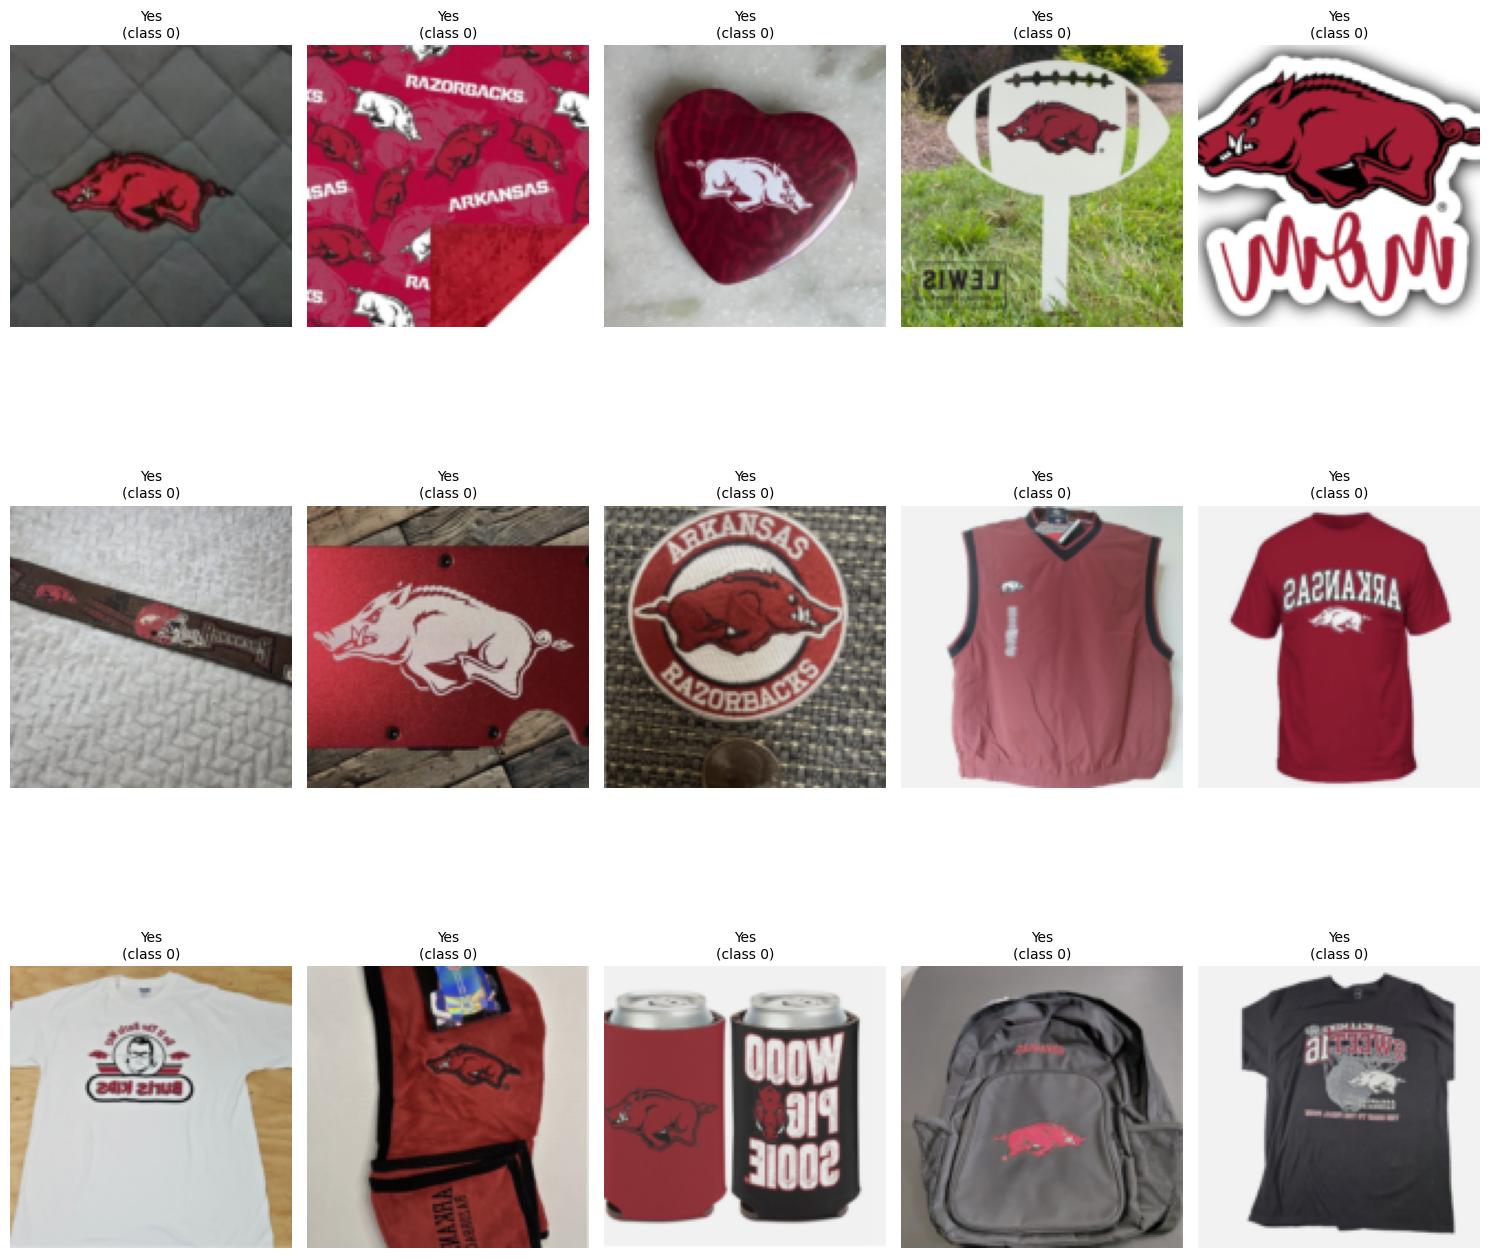

In [125]:
# Fix randomness for reproducibility
torch.manual_seed(17)

# Plot some images from the dataset with actual class names
fig = plt.figure(figsize=(15, 15))

# Show first 15 images with their actual class names
for i in range(min(15, len(dataset))):
    img, label = dataset[i]
    
    # Get the actual class name from the label
    class_name = list(dataset.class_to_idx.keys())[label]
    
    ax = fig.add_subplot(3, 5, i+1)
    ax.imshow(img)
    ax.axis("off")
    ax.set_title(f"{class_name}\n(class {label})", fontsize=10)

plt.tight_layout()
plt.show()


In [126]:
transformsToTensor = transforms.Compose([
    transforms.Resize(128),              # resize shortest side to 128, keep aspect ratio
    transforms.CenterCrop([128, 128]),   # crop to square
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

transform_test = transforms.Compose([
    transforms.Resize(128),
    transforms.CenterCrop([128, 128]),
    transforms.ToTensor()
])

dataset = ImageFolder(root=train, transform = transformsToTensor)
print('Train set:', len(dataset))

Train set: 60


In [130]:
# box 5
# Create data loa
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)
torch.manual_seed(17)

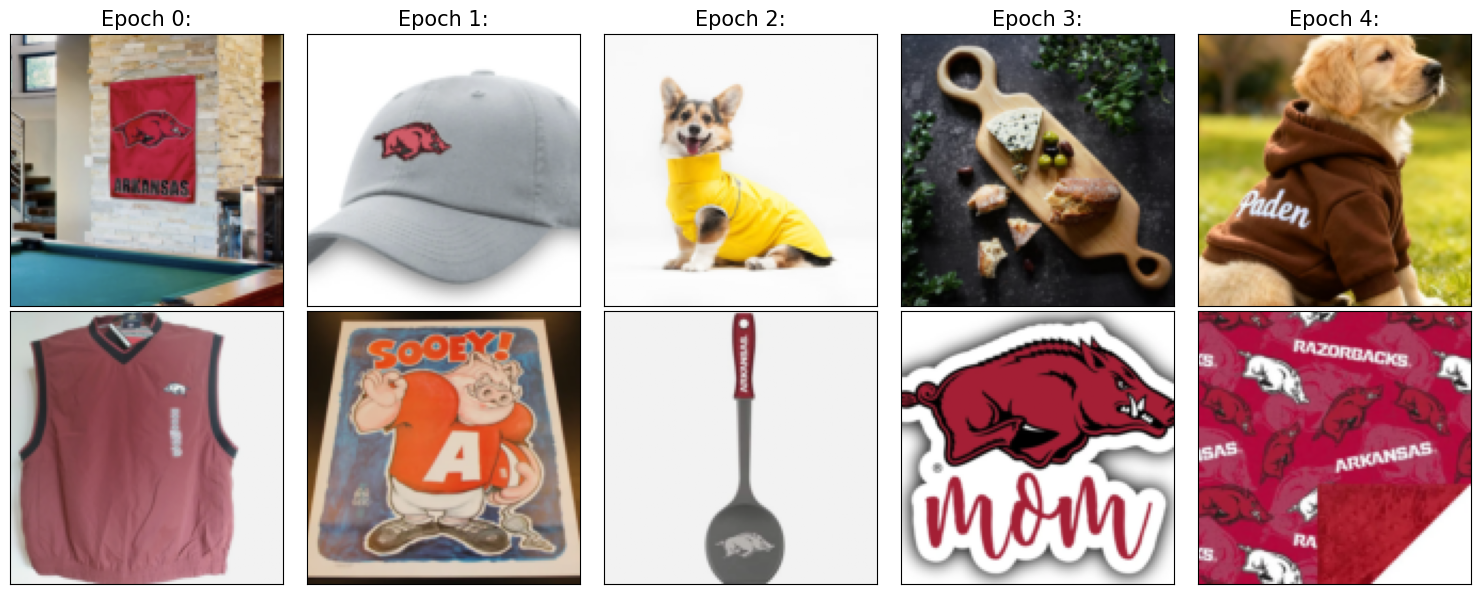

In [131]:
# Visalize how data is samplesd in different epochs
fig = plt.figure(figsize=(15, 6))

num_epochs = 5
for j in range(num_epochs):
    img_batch, label_batch = next(iter(train_loader))
    img = img_batch[0]
    ax = fig.add_subplot(2, 5, j + 1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'Epoch {j}:', size=15)
    ax.imshow(img.permute(1, 2, 0))

    img = img_batch[1]
    ax = fig.add_subplot(2, 5, j + 6)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(img.permute(1, 2, 0))

plt.tight_layout()
plt.show()

In [132]:
# Create the training and test split (using stratified split to maintain class balance)

train_size = int(0.75 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

# Get all indices and labels for stratified splitting
indices = list(range(len(dataset)))
labels = [dataset[i][1] for i in indices]

# Stratified split to maintain class proportions
train_idx, temp_idx = train_test_split(
    indices, 
    test_size=0.25,  # 25% for val+test
    stratify=labels, 
    random_state=17
)

# Split the remaining 25% into validation (40%) and test (60%)
temp_labels = [labels[i] for i in temp_idx]
val_idx, test_idx = train_test_split(
    temp_idx, 
    test_size=0.6,  # 60% of 25% = 15% of total
    stratify=temp_labels, 
    random_state=17
)

# Create subsets
from torch.utils.data import Subset
train_dataset = Subset(dataset, train_idx)
val_dataset = Subset(dataset, val_idx)
test_dataset = Subset(dataset, test_idx)

# Apply the test transforms to the test dataset
val_dataset.dataset.transform = transform_test
test_dataset.dataset.transform = transform_test

In [133]:
from collections import Counter

def count_classes_in_split(split_dataset, dataset):
    """Count how many images of each class are in a split"""
    labels = []
    for i in range(len(split_dataset)):
        _, label = split_dataset[i]
        labels.append(label)
    
    counts = Counter(labels)
    
    # Get class names
    idx_to_class = {v: k for k, v in dataset.class_to_idx.items()}
    
    print(f"Total: {len(split_dataset)} images")
    for label_idx in sorted(counts.keys()):
        class_name = idx_to_class[label_idx]
        count = counts[label_idx]
        percentage = (count / len(split_dataset)) * 100
        print(f"  {class_name} (class {label_idx}): {count} images ({percentage:.1f}%)")

print("="*60)
print("TRAINING SET:")
print("="*60)
count_classes_in_split(train_dataset, dataset)
print()

print("="*60)
print("VALIDATION SET:")
print("="*60)
count_classes_in_split(val_dataset, dataset)
print()

print("="*60)
print("TEST SET:")
print("="*60)
count_classes_in_split(test_dataset, dataset)
print()

print(f"✓ Total across all splits: {len(train_dataset) + len(val_dataset) + len(test_dataset)} / {len(dataset)}")

TRAINING SET:
Total: 45 images
  Yes (class 0): 23 images (51.1%)
  no (class 1): 22 images (48.9%)

VALIDATION SET:
Total: 6 images
  Yes (class 0): 3 images (50.0%)
  no (class 1): 3 images (50.0%)

TEST SET:
Total: 9 images
  Yes (class 0): 4 images (44.4%)
  no (class 1): 5 images (55.6%)

✓ Total across all splits: 60 / 60


In [134]:
"""I dont think we need this since our dataset is so small"""
# from torch.utils.data import Subset

# # what does this do
# # why do did we do this?
# celeba_dataset = Subset(train_dataset, torch.arange(16000))

# # what does this do
# # why do did we do this?
# celeba_valid_dataset = Subset(test_dataset, torch.arange(1000))

# print('Train set:', len(celeba_dataset))
# print('Validation set:', len(celeba_valid_dataset))

'I dont think we need this since our dataset is so small'

In [135]:
# Create data loaders
batch_size = 8

torch.manual_seed(17)
train_dl = DataLoader(train_dataset, batch_size, shuffle=True)
valid_dl = DataLoader(val_dataset, batch_size, shuffle=False)
test_dl = DataLoader(test_dataset, batch_size, shuffle=False)

In [136]:
# box 10 explain what this does overall and what it creates
model = nn.Sequential()

model.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1))
model.add_module('relu1', nn.ReLU())
model.add_module('pool1', nn.MaxPool2d(kernel_size=2))
model.add_module('dropout1', nn.Dropout(p=0.5))

model.add_module('conv2', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1))
model.add_module('relu2', nn.ReLU())
model.add_module('pool2', nn.MaxPool2d(kernel_size=2))
model.add_module('dropout2', nn.Dropout(p=0.5))

model.add_module('conv3', nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1))
model.add_module('relu3', nn.ReLU())
model.add_module('pool3', nn.MaxPool2d(kernel_size=2))

model.add_module('conv4', nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1))
model.add_module('relu4', nn.ReLU())

In [137]:
# box 11 explain overall and why we did this

x = torch.ones((4, 3, 64, 64))
model(x).shape

torch.Size([4, 256, 8, 8])

In [138]:
# box 12
# what does this do. Can we exclude? Hint:  look at chapter
model.add_module('pool4', nn.AvgPool2d(kernel_size=8))

# what does this do
model.add_module('flatten', nn.Flatten())

# what does this do..does it provide expected size
x = torch.ones((4, 3, 64, 64))
model(x).shape

torch.Size([4, 256])

In [139]:
# box 13
# what does this do
model.add_module('fc', nn.Linear(1024, 1))

# what does this do
model.add_module('sigmoid', nn.Sigmoid())

In [140]:
# box 15 explain what this does
model

Sequential(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.5, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu4): ReLU()
  (pool4): AvgPool2d(kernel_size=8, stride=8, padding=0)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=1024, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [141]:
# box 16
# what does this do
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# what does this do
model = model.to(device)

In [142]:
# box 17
# what does this do
loss_fn = nn.BCELoss()

# what does this do
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [143]:
# box 18
# explain overall
def train(model, num_epochs, train_dl, valid_dl):

    # explain this group
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs

    # what does this do
    for epoch in range(num_epochs):

        # what does this do
        model.train()

        # what does this do
        for x_batch, y_batch in train_dl:
            # what does this do
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            # what does this do
            pred = model(x_batch)[:, 0]

            # what does this do
            loss = loss_fn(pred, y_batch.float())

            # what does this do
            loss.backward()

            # what does this do
            optimizer.step()

            # what does this do
            optimizer.zero_grad()

            # what does this group do
            loss_hist_train[epoch] += loss.item()*y_batch.size(0)
            is_correct = ((pred>=0.5).float() == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.sum().cpu()

        # what does this group do
        loss_hist_train[epoch] /= len(train_dl.dataset)
        accuracy_hist_train[epoch] /= len(train_dl.dataset)

        # what does this do
        model.eval()

        # what does this do
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)
                pred = model(x_batch)[:, 0]
                loss = loss_fn(pred, y_batch.float())
                loss_hist_valid[epoch] += loss.item()*y_batch.size(0)
                is_correct = ((pred>=0.5).float() == y_batch).float()
                accuracy_hist_valid[epoch] += is_correct.sum().cpu()

        loss_hist_valid[epoch] /= len(valid_dl.dataset)
        accuracy_hist_valid[epoch] /= len(valid_dl.dataset)

        print(f'Epoch {epoch+1} accuracy: {accuracy_hist_train[epoch]:.4f} val_accuracy: {accuracy_hist_valid[epoch]:.4f}')

    # what does this function returns (do not just state the variables...describe what they represent like in a docustring)
    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid


In [144]:
# box 19
torch.manual_seed(17)

# original example had 30 but it took ~1 hour to run 15 epochs
num_epochs = 60

# what does this do
hist = train(model, num_epochs, train_dl, valid_dl)


Epoch 1 accuracy: 0.5111 val_accuracy: 0.5000
Epoch 2 accuracy: 0.4889 val_accuracy: 0.5000
Epoch 3 accuracy: 0.4889 val_accuracy: 0.5000
Epoch 4 accuracy: 0.4889 val_accuracy: 0.5000
Epoch 5 accuracy: 0.4889 val_accuracy: 0.5000
Epoch 6 accuracy: 0.4889 val_accuracy: 0.5000
Epoch 7 accuracy: 0.5333 val_accuracy: 0.5000
Epoch 8 accuracy: 0.6444 val_accuracy: 0.6667
Epoch 9 accuracy: 0.6444 val_accuracy: 0.6667
Epoch 10 accuracy: 0.5556 val_accuracy: 0.5000
Epoch 11 accuracy: 0.5778 val_accuracy: 0.5000
Epoch 12 accuracy: 0.6667 val_accuracy: 0.6667
Epoch 13 accuracy: 0.7778 val_accuracy: 0.8333
Epoch 14 accuracy: 0.7111 val_accuracy: 0.8333
Epoch 15 accuracy: 0.6000 val_accuracy: 0.8333
Epoch 16 accuracy: 0.7333 val_accuracy: 0.6667
Epoch 17 accuracy: 0.6444 val_accuracy: 0.6667
Epoch 18 accuracy: 0.7111 val_accuracy: 0.8333
Epoch 19 accuracy: 0.6000 val_accuracy: 0.6667
Epoch 20 accuracy: 0.7556 val_accuracy: 0.6667
Epoch 21 accuracy: 0.7556 val_accuracy: 0.6667
Epoch 22 accuracy: 0.8

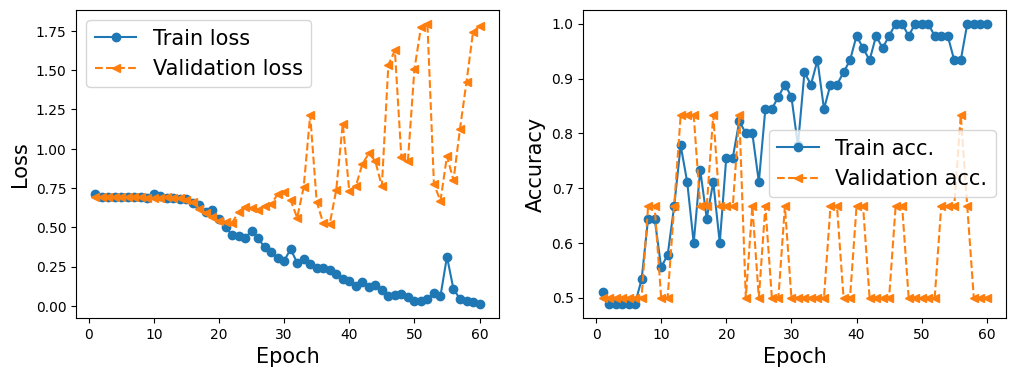

In [145]:
# Visualize training history
x_arr = np.arange(len(hist[0])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist[0], '-o', label='Train loss')
ax.plot(x_arr, hist[1], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist[2], '-o', label='Train acc.')
ax.plot(x_arr, hist[3], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

#plt.savefig('figures/14_17.png', dpi=300)
plt.show()

In [146]:
# Look at test accuracy
accuracy_test = 0

# what does this do
model.eval()

# what does this do
with torch.no_grad():
    for x_batch, y_batch in test_dl:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        pred = model(x_batch)[:, 0]
        is_correct = ((pred>=0.5).float() == y_batch).float()
        accuracy_test += is_correct.sum().cpu()

accuracy_test /= len(test_dl.dataset)

print(f'Test accuracy: {accuracy_test:.4f}')

Test accuracy: 0.6667


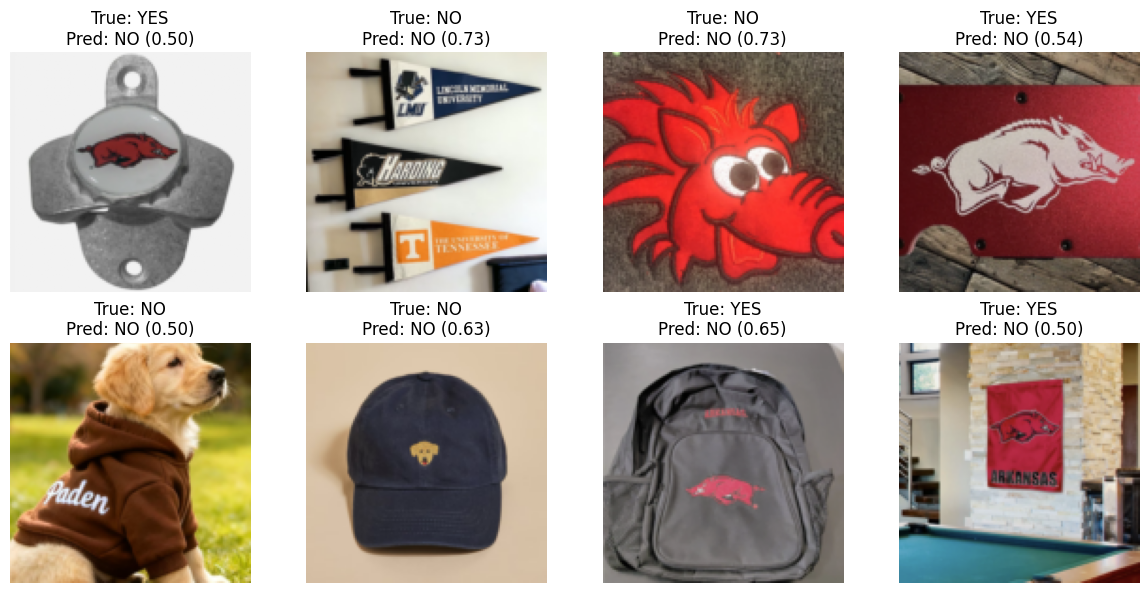

In [147]:
import matplotlib.pyplot as plt
import torch

# get one batch from validation (or training)
x_batch, y_batch = next(iter(test_dl))

# move to device
x_batch = x_batch.to(device)

# get model predictions
model.eval()
with torch.no_grad():
    preds = torch.sigmoid(model(x_batch)[:, 0])

# move back to CPU for visualization
x_batch = x_batch.cpu()
preds = preds.cpu()
y_batch = y_batch.cpu()

# plot images with predictions
batch_size = len(x_batch)
num_images = min(16, batch_size)

# calculate grid size
cols = 4
rows = (num_images + cols - 1) // cols  # ceiling division

plt.figure(figsize=(12, rows * 3))

for i in range(num_images):
    plt.subplot(rows, cols, i+1)
    
    img = x_batch[i].permute(1, 2, 0)  # CHW → HWC
    plt.imshow(img)
    
    true_label = "NO" if y_batch[i] == 1 else "YES"
    pred_label = "NO" if preds[i] >= 0.5 else "YES"
    prob = preds[i].item()
    
    plt.title(f"True: {true_label}\nPred: {pred_label} ({prob:.2f})")
    plt.axis("off")

plt.tight_layout()
plt.show()

In [148]:
# box 23

# what does this do
import os

# what does this do
if not os.path.exists('models'):
    os.mkdir('models')

path = 'models/celeba-cnn.ph'

# what does this do
torch.save(model, path)

In [149]:
# box 24
path = 'models/celeba-cnn.ph'

# what does this do
loaded_full_model = torch.load(path, weights_only=False)

# what does this do
loaded_full_model.eval()

Sequential(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.5, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu4): ReLU()
  (pool4): AvgPool2d(kernel_size=8, stride=8, padding=0)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=1024, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [25]:
# box 25

from PIL import Image
image_path = 'FILENAME.jpg'

# what does this do
img = Image.open(image_path).convert('RGB')

# what does this do
img_tensor = transform(img).unsqueeze(0)

# what does this do
with torch.no_grad():
    # what does this do
    logit = loaded_full_model(img_tensor)

    # what does this do
    probability = torch.sigmoid(logit).item()

# what does this group do
plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.title(f"Image to Classify: {os.path.basename(image_path)}")
plt.axis('off')
plt.show()
print(f"Classification Result:")
print(f"pr(Smile): {probability:.4f}")

# what does this do
label = "SMILE" if probability >= 0.5 else "NOT SMILING"
print(f"Predicted Class: {label}")

FileNotFoundError: [Errno 2] No such file or directory: '/Users/lucasjones/Documents/GitHub/MachineLearningProject3/FILENAME.jpg'